In [1]:
import tensorflow as tf
from makiflow.models.classificator import Classificator
from makiflow.metrics import bin_categorical_dice_coeff
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pandas as pd
import json
from tqdm import tqdm
%matplotlib inline

from makiflow import set_main_gpu
set_main_gpu(';')

In [2]:
N_CLASSES = 8
IMAGE_SHAPE = (1024, 1024)

In [3]:
SESSION = tf.Session()

In [23]:
def create_model(arch_path, weights_path):
    model = Classificator.from_json(arch_path)
    model.set_session(SESSION)
    model.load_weights(weights_path)
    return model

def load_im_mask(image_path, masks_folder_path):
    image_shape = IMAGE_SHAPE
    n_classes = N_CLASSES
    image = cv2.imread(image_path)

    mask_folder = masks_folder_path

    label_tensor = np.zeros(shape=(*image_shape, n_classes + 1), dtype='int32')
    for binary_mask_path in glob(os.path.join(mask_folder, '*')):
        filename = binary_mask_path.split('/')[-1]
        class_id = int(filename.split('.')[0])
        assert class_id != 0, 'Encountered class 0. Class names must start from 1.'
        binary_mask = cv2.imread(binary_mask_path)
        assert binary_mask is not None, f'Could not load mask with name={binary_mask_path}'
        label_tensor[..., class_id] = binary_mask[..., 0] * class_id
    label_tensor = np.max(label_tensor, axis=-1)
    
    return image.astype(np.float32, copy=False) / 255, label_tensor

def load_data(config_path):
    config = load_json(config_path)
    config = config['test_config']
    image_paths = config['test_image']
    mask_paths = config['test_mask']
    
    images = []
    masks = []
    for image_path, mask_folder_path in zip(image_paths, mask_paths):
        image, mask = load_im_mask(image_path, mask_folder_path)
        images.append(image)
        masks.append(mask)
    return images, masks

def load_json(path):
    with open(path, 'r') as f:
        return json.loads(f.read())

def test(arch_path, weights_path, config_path, th=0.5):
    images, masks = load_data(config_path)
    model = create_model(arch_path, weights_path)
    
    predictions = []
    max_preds = []
    for image in tqdm(images):
        pred = (model.predict([image])[0] > th).astype('uint8') * np.arange(1, 9, 1).reshape(1, 1, 8)
#         pred = pred.max(axis=-1)
        predictions += [pred]
        max_preds += [pred.max(axis=-1)]
    
    # predictions = np.concatenate(predictions, axis=0)
    f1_scores = f1_score(np.asarray(masks).reshape(-1), np.asarray(max_preds).reshape(-1), average=None)
    return confusion_matrix(np.asarray(masks).reshape(-1), np.asarray(max_preds).reshape(-1)), f1_scores


def compute_tpr_tnr_class(class_id, C):
    TN = C[0, 0]
    TP = C[class_id, class_id]
    
    FP = 0
    for i in range(0, C.shape[0]):
        if i == class_id:
            continue
        FP += C[i, class_id]
        
    FN = 0
    for i in range(0, C.shape[0]):
        if i == class_id:
            continue
        FN += C[class_id, i]
    
    tpr = 1 - FN / (FN + TP + 1e-7)
    tnr = 1 - FP / (FP + TN + 1e-7)
    acc = (TP + TN) / (TP + TN + FP + FN)
    return tpr, tnr, acc
    
def compute_tpr(C):
    trps = []
    tnrs = []
    accs = []
    for i in range(1, C.shape[0]):
        rates = compute_tpr_tnr_class(i, C)
        trps.append(rates[0])
        tnrs.append(rates[1])
        accs.append(rates[2])
    return trps, tnrs, accs

In [35]:
cv3_f0_model_arch = 'cv3_fold0/result/model.json'
cv3_f0_model_weights = 'cv3_fold0/result/last_weights/weights.ckpt'
cv3_f0_config = 'cv3_fold0/config.json'

cv3_f0_C, f1_scores_1 = test(cv3_f0_model_arch, cv3_f0_model_weights, cv3_f0_config, 0.5)

Model is restored!
INFO:tensorflow:Restoring parameters from cv3_fold0/result/last_weights/weights.ckpt


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Weights are loaded.



1it [00:04,  4.45s/it]
 12%|█▎        | 1/8 [00:08<00:59,  8.56s/it]
0it [00:00, ?it/s]
1it [00:03,  3.02s/it]
 25%|██▌       | 2/8 [00:11<00:41,  6.92s/it]
0it [00:00, ?it/s]
1it [00:03,  3.21s/it]
 38%|███▊      | 3/8 [00:18<00:33,  6.77s/it]
0it [00:00, ?it/s]
1it [00:03,  3.15s/it]
 50%|█████     | 4/8 [00:24<00:26,  6.61s/it]
0it [00:00, ?it/s]
1it [00:02,  2.93s/it]
 62%|██████▎   | 5/8 [00:30<00:19,  6.49s/it]
0it [00:00, ?it/s]
1it [00:03,  3.12s/it]
 75%|███████▌  | 6/8 [00:36<00:12,  6.45s/it]
0it [00:00, ?it/s]
1it [00:03,  3.04s/it]
 88%|████████▊ | 7/8 [00:43<00:06,  6.37s/it]
0it [00:00, ?it/s]
1it [00:02,  3.00s/it]
100%|██████████| 8/8 [00:49<00:00,  6.17s/it]


In [36]:
tpr0, tnr0, accs0 = np.array(compute_tpr(cv3_f0_C)).round(2)

In [37]:
tpr0

array([0.99, 0.76, 0.91, 0.8 , 0.11, 0.44, 0.23, 0.79])

In [38]:
cv3_f1_model_arch = 'cv3_fold1/result/model.json'
cv3_f1_model_weights = 'cv3_fold1/result/last_weights/weights.ckpt'
cv3_f1_config = 'cv3_fold1/config.json'

cv3_f1_dice, f1_scores_2 = test(cv3_f1_model_arch, cv3_f1_model_weights, cv3_f1_config, 0.5)

Model is restored!
INFO:tensorflow:Restoring parameters from cv3_fold1/result/last_weights/weights.ckpt


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Weights are loaded.



1it [00:04,  4.69s/it]
 12%|█▎        | 1/8 [00:04<00:34,  4.90s/it]
0it [00:00, ?it/s]
1it [00:03,  3.02s/it]
 25%|██▌       | 2/8 [00:11<00:31,  5.29s/it]
0it [00:00, ?it/s]
1it [00:03,  3.18s/it]
 38%|███▊      | 3/8 [00:14<00:23,  4.76s/it]
0it [00:00, ?it/s]
1it [00:03,  3.17s/it]
 50%|█████     | 4/8 [00:20<00:20,  5.21s/it]
0it [00:00, ?it/s]
1it [00:03,  3.03s/it]
 62%|██████▎   | 5/8 [00:27<00:16,  5.49s/it]
0it [00:00, ?it/s]
1it [00:03,  3.02s/it]
 75%|███████▌  | 6/8 [00:33<00:11,  5.72s/it]
0it [00:00, ?it/s]
1it [00:02,  2.96s/it]
 88%|████████▊ | 7/8 [00:39<00:05,  5.82s/it]
0it [00:00, ?it/s]
1it [00:03,  3.09s/it]
100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


In [39]:
tpr1, tnr1, accs1 = np.array(compute_tpr(cv3_f1_dice)).round(2)

In [40]:
tpr1

array([0.97, 0.62, 0.91, 0.89, 0.52, 0.01, 0.61, 0.94])

In [41]:
cv3_f2_model_arch = 'cv3_fold2/result/model.json'
cv3_f2_model_weights = 'cv3_fold2/result_2/last_weights/weights.ckpt'
cv3_f2_config = 'cv3_fold2/config.json'

cv3_f2_dice, f1_scores_3 = test(cv3_f2_model_arch, cv3_f2_model_weights, cv3_f2_config, 0.5)

Model is restored!
INFO:tensorflow:Restoring parameters from cv3_fold2/result_2/last_weights/weights.ckpt


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Weights are loaded.



1it [00:04,  4.97s/it]
 12%|█▎        | 1/8 [00:05<00:35,  5.03s/it]
0it [00:00, ?it/s]
1it [00:02,  2.93s/it]
 25%|██▌       | 2/8 [00:11<00:32,  5.38s/it]
0it [00:00, ?it/s]
1it [00:05,  5.78s/it]
 38%|███▊      | 3/8 [00:18<00:29,  5.93s/it]
0it [00:00, ?it/s]
1it [00:03,  3.45s/it]
 50%|█████     | 4/8 [00:23<00:22,  5.62s/it]
0it [00:00, ?it/s]
1it [00:03,  3.41s/it]
 62%|██████▎   | 5/8 [00:28<00:16,  5.41s/it]
0it [00:00, ?it/s]
1it [00:03,  3.29s/it]
 75%|███████▌  | 6/8 [00:31<00:09,  4.82s/it]
0it [00:00, ?it/s]
1it [00:03,  3.15s/it]
 88%|████████▊ | 7/8 [00:40<00:06,  6.06s/it]
0it [00:00, ?it/s]
1it [00:03,  3.46s/it]
100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


In [42]:
tpr2, tnr2, accs2 = np.array(compute_tpr(cv3_f2_dice)).round(2)

In [43]:
f1_scores_1 = f1_scores_1[1:].round(2)
f1_scores_1 = np.hstack([f1_scores_1, np.mean(f1_scores_1).round(2)])
f1_scores_2 = f1_scores_2[1:].round(2)
f1_scores_2 = np.hstack([f1_scores_2, np.mean(f1_scores_2).round(2)])
f1_scores_3 = f1_scores_3[1:].round(2)
f1_scores_3 = np.hstack([f1_scores_3, np.mean(f1_scores_3).round(2)])

In [44]:
tpr0 = np.hstack([tpr0, np.mean(tpr0).round(2)])
tpr1 = np.hstack([tpr1, np.mean(tpr1).round(2)])
tpr2 = np.hstack([tpr2, np.mean(tpr2).round(2)])

tnr0 = np.hstack([tnr0, np.mean(tnr0).round(2)])
tnr1 = np.hstack([tnr1, np.mean(tnr1).round(2)])
tnr2 = np.hstack([tnr2, np.mean(tnr2).round(2)])

accs0 = np.hstack([accs0, np.mean(accs0).round(2)])
accs1 = np.hstack([accs1, np.mean(accs1).round(2)])
accs2 = np.hstack([accs2, np.mean(accs2).round(2)])

In [45]:
mean_tpr = np.mean([tpr0, tpr1, tpr2], axis=0).round(2)
mean_tnr = np.mean([tnr0, tnr1, tnr2], axis=0).round(2)
mean_acc = np.mean([accs0, accs1, accs2], axis=0).round(2)
mean_tpr, mean_tnr, mean_acc

(array([0.98, 0.72, 0.91, 0.85, 0.31, 0.19, 0.46, 0.82, 0.65]),
 array([0.98, 0.99, 0.75, 0.98, 1.  , 1.  , 0.99, 0.97, 0.96]),
 array([0.98, 0.99, 0.76, 0.98, 1.  , 1.  , 0.99, 0.97, 0.96]))

In [46]:
ba = (mean_tpr + mean_tnr) / 2
ba

array([0.98 , 0.855, 0.83 , 0.915, 0.655, 0.595, 0.725, 0.895, 0.805])

In [47]:
mean_f1 = np.mean([f1_scores_1, f1_scores_2, f1_scores_3], axis=0).round(2)
mean_f1

array([0.75, 0.66, 0.48, 0.47, 0.34, 0.21, 0.26, 0.47, 0.46])

In [48]:
df = pd.DataFrame(
    data=np.stack([tpr0, tpr1, tpr2, f1_scores_1, f1_scores_2, f1_scores_3, mean_tpr, mean_tnr, mean_f1, mean_acc, ba]), 
    index=['test0 tpr', 'test1 tpr', 'test2 tpr', 'test0 f1',
           'test1 f1', 'test2 f1', 'mean_tpr', 'mean_tnr', 'mean_f1', 'mean_acc', 'ba'],
    columns=list(range(1,9)) + ['mean']
)

In [49]:
df.to_csv('tpr_oversampling_p0.5.csv')

In [21]:
SESSION

In [72]:
model = create_model(cv3_f1_model_arch, cv3_f1_model_weights)

Model is restored!
INFO:tensorflow:Restoring parameters from cv3_fold1/result/last_weights/weights.ckpt
Weights are loaded.


In [73]:
data = load_data(cv3_f1_config)

In [74]:
images, masks = data

In [75]:
masks[0].shape

(1024, 1024)

In [76]:
mask = model.predict([images[0]])[0]

1it [00:04,  4.58s/it]


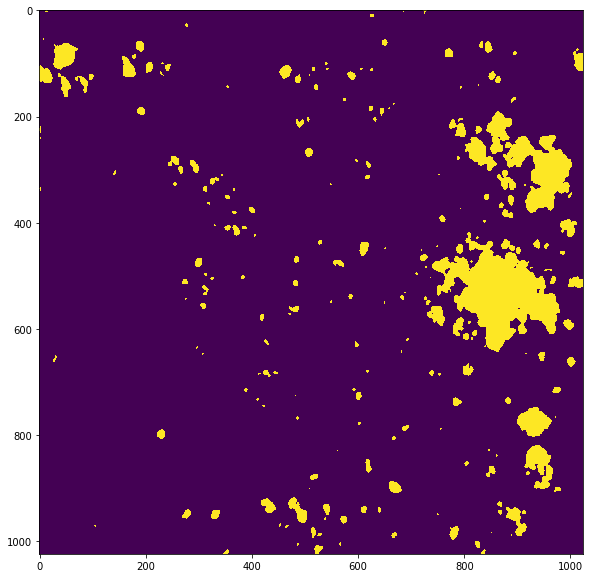

In [77]:
plt.figure(figsize=(10, 10))
plt.imshow(mask[..., 7] > 0.5)

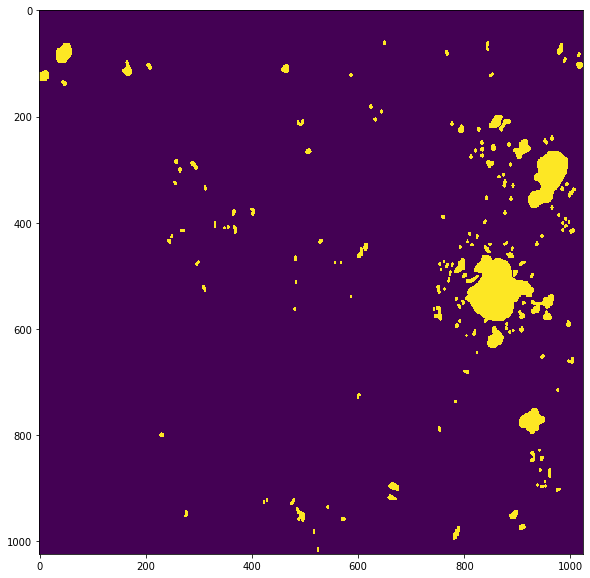

In [78]:
plt.figure(figsize=(10, 10))
plt.imshow(masks[0]==8)

In [84]:
def stack_mask(mask):
    return np.stack([np.round(mask) * 255] * 3, axis=-1).astype('uint8')

In [85]:
cv2.imwrite('pred_f1_im0.png', stack_mask(mask[..., 7] > 0.5))

True

In [86]:
cv2.imwrite('mask_f1_im0.png', stack_mask(masks[0]==8))

True